### Investigating Overlap of networks

Fiest stage: Computing Network Overlap using Normalized Mutual Information (NMI) \
Normalized Mutual Information (NMI) is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation).

Plan: 
1. Load each network from a .pkl file
2. Detect communities in each network (using Louvain method?).
3. Align the hashtag nodes across networks - taking the same hashtags only.
4. Compute the Normalized Mutual Information (NMI) between all pairs.

## Computing NMI based on community structures detected in each network.

In [1]:
import pickle
import networkx as nx
from community import community_louvain
from sklearn.metrics import normalized_mutual_info_score
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from node2vec import Node2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from tqdm import tqdm

In [2]:
network_files = {
    "cooccurrence": "../ready_networks/cooc_filtered.pkl",
    "likes": "../ready_networks/likes_network.pkl",
    "follower": "../ready_networks/follow_filtered.pkl",
    "duet_stitch": "../ready_networks/ds_network.pkl"
}

In [3]:
networks = {name: pickle.load(open(path, 'rb')) for name, path in network_files.items()}

In [35]:
#Detect communities using Louvain
def detect_communities(G):
    if G.is_directed(): # had to convert the networks to undirected for louvain
        G = nx.Graph(G)  # preserves edge weights, merges reverse edges
    return community_louvain.best_partition(G)

communities = {name: detect_communities(G) for name, G in networks.items()}


In [36]:
#filtering - get only common hashtags (nodes) across all networks
common_nodes = set.intersection(*[set(G.nodes()) for G in networks.values()])


In [37]:
#Align community labels for common nodes
community_labels = {}
for name, comm_dict in communities.items():
    labels = [comm_dict[node] for node in common_nodes]
    community_labels[name] = labels


In [38]:
# Step 4: Compute NMI for all network pairs
nmi_scores = []
network_names = list(community_labels.keys())

for network1, network2 in itertools.combinations(network_names, 2):
    nmi = normalized_mutual_info_score(community_labels[network1], community_labels[network2])
    nmi_scores.append((network1, network2, nmi))

df_nmi = pd.DataFrame(nmi_scores, columns=["Network 1", "Network 2", "NMI Score"])
print(df_nmi)

      Network 1    Network 2  NMI Score
0  cooccurrence        likes   0.424524
1  cooccurrence     follower   0.503439
2  cooccurrence  duet_stitch   0.328750
3         likes     follower   0.424238
4         likes  duet_stitch   0.378132
5      follower  duet_stitch   0.340740


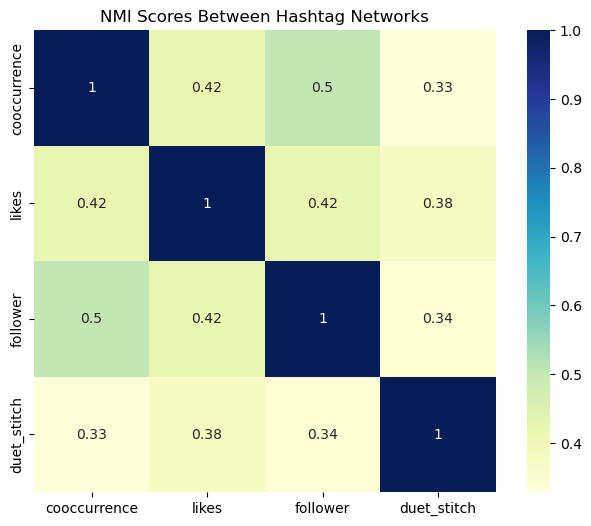

In [39]:
#Heatmap of NMI Scores

#symmetric matrix for heatmap
networks = ['cooccurrence', 'likes', 'follower', 'duet_stitch']
heatmap_data = pd.DataFrame(index=networks, columns=networks, data=1.0)

for _, row in df_nmi.iterrows():
    n1, n2, score = row
    heatmap_data.loc[n1, n2] = score
    heatmap_data.loc[n2, n1] = score

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.astype(float), annot=True, cmap='YlGnBu', square=True)
plt.title('NMI Scores Between Hashtag Networks')
plt.show()


## Visualizing the semantic overlap between networks on a sample of hashtags for better understanding of results

### Network Diagram of Community Overlap

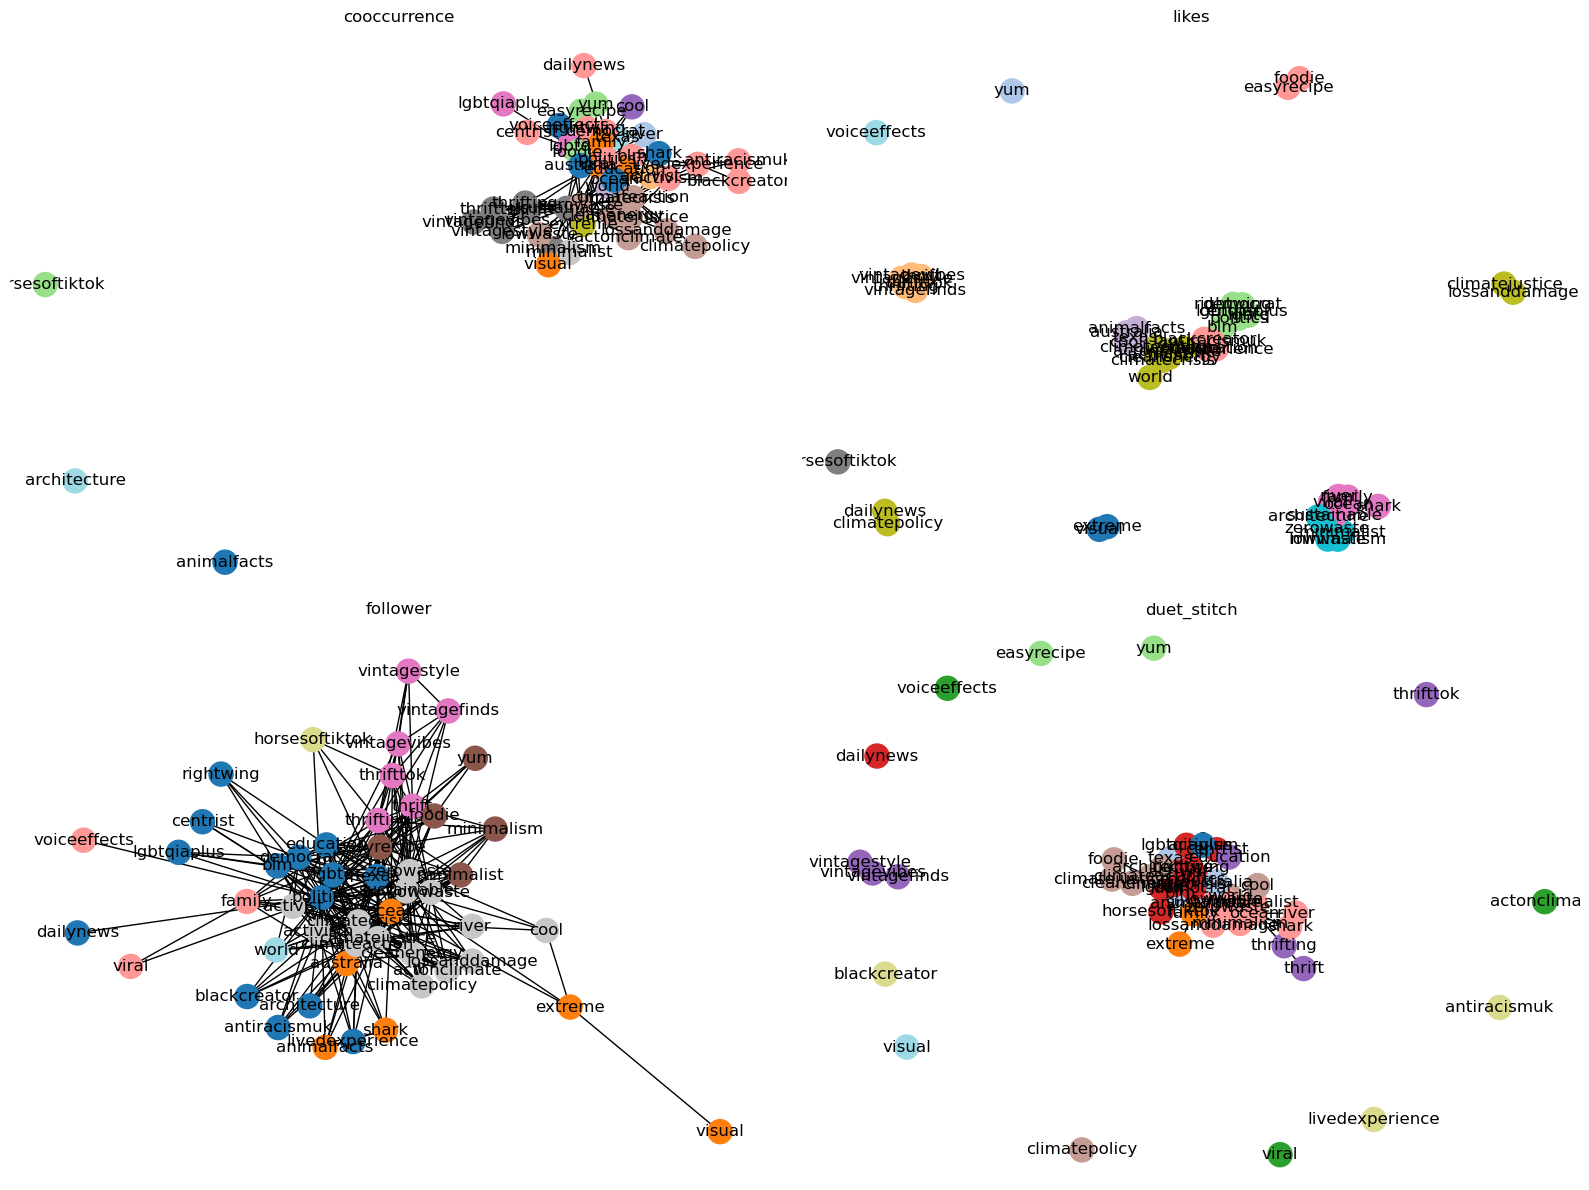

In [40]:
# subset of common hashtags
networks = {name: pickle.load(open(path, 'rb')) for name, path in network_files.items()}
sample_hashtags = random.sample(list(common_nodes), 50)

def draw_network(G, communities, title):
    subgraph = G.subgraph(sample_hashtags)
    pos = nx.spring_layout(subgraph, seed=42)
    colors = [communities[n] for n in subgraph.nodes()]
    nx.draw(subgraph, pos, node_color=colors, with_labels=True, cmap=plt.cm.tab20, node_size=300)
    plt.title(title)

plt.figure(figsize=(16, 12))

for i, (name, G) in enumerate(networks.items(), 1):
    if G.is_directed():
        G = G.to_undirected()
    comms = community_louvain.best_partition(G)
    plt.subplot(2, 2, i)
    draw_network(G, comms, name)

plt.tight_layout()
plt.show()

#Note:
#result = 4 plots — one per network — with the same subset of hashtags, colored by community membership in that network

### Attempt to visualise: how hashtags shift between communities across networks, like tracing how meaning or context flows depending on user behavior

### Sankey diagram
Each column is a different network ( Co-occurrence → Likes → Follower → Duet_Stitch)

Each node is a community in that network (e.g., Co-Comm-0, Likes-Comm-1).

Flows (links) represent hashtags that appear in one community in a network and move to another community in the next network.

In [ ]:
#For each hashtag and each network, store its community label.
# 1. Detect communities

for name, G in networks.items(): # again converting directed to undirected
    if G.is_directed():
        networks[name] = G.to_undirected()

# Detect communities
communities = {}
for name, G in networks.items():
    partition = community_louvain.best_partition(G)
    communities[name] = {node: partition[node] for node in common_nodes}


In [43]:
# 2.  Building Hashtag Flow Between Networks
from collections import defaultdict
# List of network names in sequence
network_order = ["cooccurrence", "likes", "follower", "duet_stitch"]

# Prepare flows: (source_community, target_community, count)
flows = defaultdict(int)

for hashtag in common_nodes:
    for i in range(len(network_order) - 1):
        net1 = network_order[i]
        net2 = network_order[i + 1]
        comm1 = f"{net1}-C{communities[net1][hashtag]}"
        comm2 = f"{net2}-C{communities[net2][hashtag]}"
        flows[(comm1, comm2)] += 1


In [ ]:
# 3. Getting Sankey Diagram using Plotly
import plotly.graph_objects as go

# Get unique community labels
labels = sorted(set([src for src, _ in flows] + [tgt for _, tgt in flows]))
label_to_idx = {label: i for i, label in enumerate(labels)}

# Build Sankey links
source = [label_to_idx[src] for src, tgt in flows]
target = [label_to_idx[tgt] for src, tgt in flows]
value = [count for count in flows.values()]

# Plot
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.update_layout(title_text="Hashtag Community Flow Across Networks", font_size=10)
fig.show()


Conclusions for the report:

If for example a lot of hashtags move from Co-occurrence:Community 0 to Likes:Community 2, 
it suggests that semantically related tags (through content) are grouped differently when viewed via user liking behavior.

Motivation for the report: (wstawka)

**"Drift patterns may help understand how trends are reshaped by user interaction types."**

### Quantative analysis

1. Community Stability / Consistency - How stable a hashtag’s community assignment is across networks.

Metric:
Entropy of community assignments per hashtag (Maximum entropy: when a value is equally spread across all possible options.
)

Mozna jeszcze sprawdzic inne metrics:

Jaccard similarity or Rand Index between communities across networks

Average number of distinct communities a hashtag belongs to across networks

In [ ]:
from scipy.stats import entropy
import numpy as np

# For each hashtag - count how often it appears in each community across networks
hashtag_flows = {}

for hashtag in common_nodes:
    community_path = tuple(communities[net][hashtag] for net in network_order)
    hashtag_flows[hashtag] = community_path

# Community entropy for each hashtag
hashtag_entropy = {
    h: entropy(np.bincount(list(path)))
    for h, path in hashtag_flows.items()
}
avg_entropy = np.mean(list(hashtag_entropy.values()))
print(avg_entropy)

#Output = 1.28 -> High drift. Hashtag is assigned to multiple communities, indicating semantic fluidity.

1.2826152134096838


2. Drift Score - How much a hashtag's community membership changes from one network to the next.

Mozna tez obczaic  
Metric: Hamming distance between community vectors

In [ ]:
def drift_score(path):
    return sum([path[i] != path[i+1] for i in range(len(path)-1)])

avg_drift_score = np.mean([drift_score(path) for path in hashtag_flows.values()])
print(avg_drift_score)
# Output = 2.8 -> hashtags are changing their community assignments 2.8 times between the networks.

2.806896551724138


**Report wstawka:**

The drift score metric helps to understand the degree of semantic movement or fluidity of hashtags across different interaction contexts. It’s valuable for tracking how consistent or diverse a hashtag's role is across user actions.

# Semantic Comparison Across Networks


Semantic comparison of networks using graph embeddings

- Node2Vec for embedding
- cosine similarity for comparing

In [4]:
#embedding each network using Node2Vec ; standard variables
def embed_graph(graph, dimensions=64, walk_length=30, num_walks=200, window=10):
    node2vec = Node2Vec(graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=1)
    model = node2vec.fit(window=window, min_count=1)
    return model

#finding common emb.(hashtags) across each pair
def get_common_embeddings(model1, model2):
    common_nodes = list(set(model1.wv.key_to_index) & set(model2.wv.key_to_index))
    if not common_nodes:
        return None, None, []
    emb1 = np.array([model1.wv[node] for node in common_nodes])
    emb2 = np.array([model2.wv[node] for node in common_nodes])
    return emb1, emb2, common_nodes

# coputing similarity of their embeddings
def compare_graph_embeddings(networks):
    embeddings = {}
    similarities = {}

    # Step 1: Embed all graphs
    print("Embedding graphs...")
    for name, graph in tqdm(networks.items()):
        embeddings[name] = embed_graph(graph)

    # Step 2: Compare each pair
    print("\nComparing pairs...")
    for (name1, model1), (name2, model2) in combinations(embeddings.items(), 2):
        emb1, emb2, common_nodes = get_common_embeddings(model1, model2)
        if emb1 is None or len(common_nodes) == 0:
            similarities[(name1, name2)] = None
            continue

        # Cosine similarity for corresponding embeddings
        cos_sim = cosine_similarity(emb1, emb2)
        avg_similarity = np.mean(np.diag(cos_sim))  # same nodes across models

        similarities[(name1, name2)] = {
            "average_similarity": avg_similarity,
            "num_common_hashtags": len(common_nodes),
            "hashtag_similarities": dict(zip(common_nodes, np.diag(cos_sim)))
        }

    return similarities

In [ ]:
# comparing loaded in networks before
results = compare_graph_embeddings(networks)

Embedding graphs...


  0%|          | 0/4 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/39665 [00:00<?, ?it/s]

In [ ]:
#Output results for all pairs across all networks
for pair, data in results.items():
    if data:
        print(f"{pair[0]} vs {pair[1]}: Avg Similarity = {data['average_similarity']:.4f}, Common Hashtags = {data['num_common_hashtags']}")